In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np
from collections import defaultdict
from procgen_tools import models

### Load the data and define some helpers

In [2]:
vfields = []
for f in glob('../data/vfields/seed-*.pkl'):
    with open(f, 'rb') as fp:
        vfields.append(pickle.load(fp))

len(vfields)

1000

In [3]:
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)

In [4]:
def get_vfields(seed: int, coef: float):
    for vf in vfields_by_level[seed]:
        if vf['coeff'] == coef:
            return vf

### Interactive vfield plot explorer

In [5]:
from ipywidgets import interact, IntSlider, FloatSlider

seed_max = max(vf['seed'] for vf in vfields)
min_coeff, max_coeff = min(vf['coeff'] for vf in vfields), max(vf['coeff'] for vf in vfields)

def _coeffs_for(seed: int):
    return sorted(set(vf['coeff'] for vf in vfields_by_level[seed]))

def plot_vfs(vfs):
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    for i, vf in enumerate((vfs['original_vfield'], vfs['patched_vfield'])):
        legal_mouse_positions, arrows, grid = vf['legal_mouse_positions'], vf['arrows'], vf['grid']

        ax[i].set_xlabel("Original vfield" if i == 0 else "Patched vfield")
        ax[i].quiver(
            [x[1] for x in legal_mouse_positions], [x[0] for x in legal_mouse_positions],
            [x[1] for x in arrows], [x[0] for x in arrows], color='red',
        )
        ax[i].imshow(grid, origin='lower')

    plt.title(f"Seed {vfs['seed']}, coeff {vfs['coeff']}")
    plt.show()


@interact(seed = IntSlider(min=0, max=99, step=1, value=0), coeff = FloatSlider(min=min_coeff, max=max_coeff, step=0.1, value=1.0))
def interact_vfields(seed: int, coeff: float):
    # set coeff to nearest available in vfields_by_level[seed]
    coeff = min(_coeffs_for(seed), key=lambda x: abs(x - coeff))
    vfs = get_vfields(seed, coeff)
    plot_vfs(vfs)


interactive(children=(IntSlider(value=0, description='seed', max=99), FloatSlider(value=1.0, description='coef…

### Get dot products with cheese direction

In [6]:
from procgen_tools import maze

def similarity(t1, t2):
    return np.dot(t1, t2) / (np.linalg.norm(t1) * np.linalg.norm(t2))

# TODO: Test & visualize this, could very easily be wrong
def cheese_direction_similarity(vf):
    (cx, cy) = maze.get_cheese_pos(vf['grid'])
    sims = []
    for (mx, my), (ax, ay) in zip(vf['legal_mouse_positions'], vf['arrows']):
        sims.append(similarity((cx - mx, cy - my), (ax, ay)))
    return sims

In [7]:
sims_original = []
sims_patched = []

def _avg_sim(vf):
    return sum(cheese_direction_similarity(vf)) / len(vf['legal_mouse_positions'])

for vfs in filter(lambda vf: vf['coeff'] == -1.0, vfields):
    sims_original.append(_avg_sim(vfs['original_vfield']))
    sims_patched.append(_avg_sim(vfs['patched_vfield']))

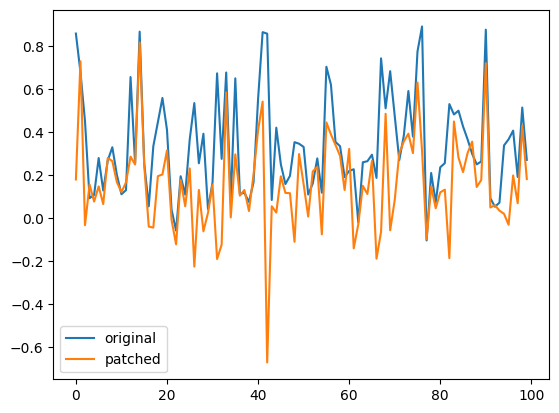

In [8]:
plt.plot(sims_original, label='original')
plt.plot(sims_patched, label='patched')
plt.legend()
plt.show()

In [9]:
np.array(sims_original).mean(), np.array(sims_patched).mean()

(0.33833466611951807, 0.16233375006140116)

In [10]:
import scipy.stats as stats
line = stats.linregress(sims_patched, sims_original)
line

LinregressResult(slope=0.42745029969529863, intercept=0.2689450560051104, rvalue=0.4003174986869518, pvalue=3.678519272712933e-05, stderr=0.09884209907149188, intercept_stderr=0.026921597981669994)

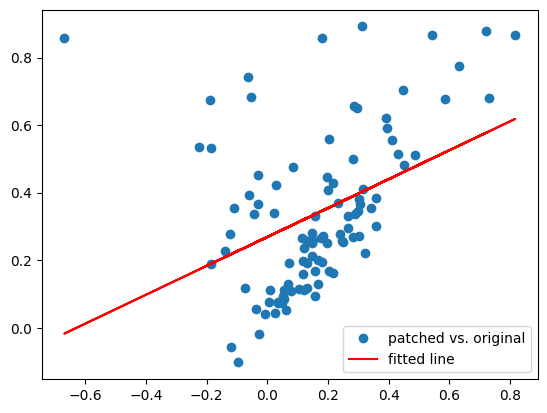

In [11]:
# plot regression line from scipy
plt.plot(sims_patched, sims_original, 'o', label='patched vs. original')
plt.plot(sims_patched, line.intercept + line.slope*np.array(sims_patched), 'r', label='fitted line')
plt.legend()
plt.show()

### Check dot product sim at decision squares

In [12]:
from procgen_tools import metrics

def _decision_square_index(vf):
    return vf['legal_mouse_positions'].index(metrics.decision_square(vf['grid']))

def decision_square_similarity(vf):
    i = _decision_square_index(vf)
    (dx, dy) = metrics.decision_square(vf['grid'])
    (cx, cy) = maze.get_cheese_pos(vf['grid'])

    return similarity((cx - dx, cy - dy), vf['arrows'][i])

-0.7619792970488185


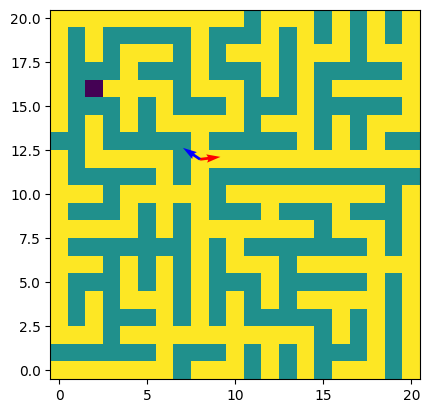

In [13]:
vfs = vfields[4]
vf = vfs['original_vfield']
i = _decision_square_index(vf)
dsq = metrics.decision_square(vf['grid'])
csq = maze.get_cheese_pos(vf['grid'])

plt.imshow(vf['grid'], origin='lower')
plt.quiver(dsq[1], dsq[0], [vf['arrows'][i][1]], [vf['arrows'][i][0]], color='red')
plt.quiver(dsq[1], dsq[0], [csq[1]-dsq[1]], [csq[0]-dsq[0]], color='blue')
print(decision_square_similarity(vf))
plt.show()

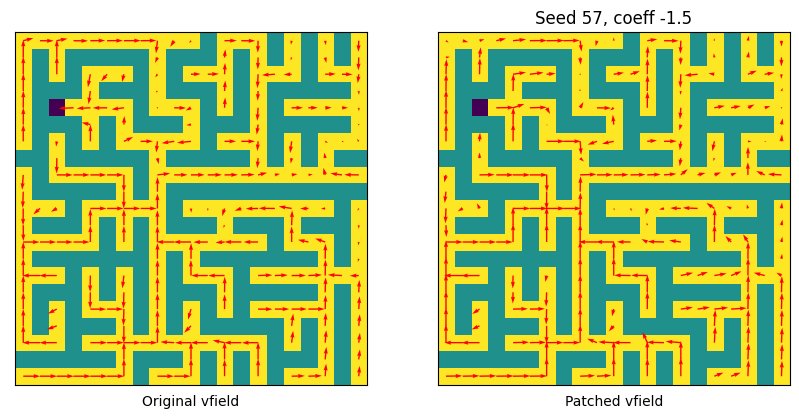

In [14]:
plot_vfs(vfs)

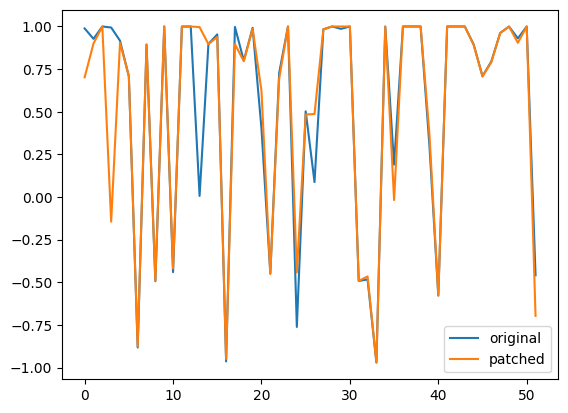

In [15]:
dsq_sim_original = []
dsq_sim_patched = []

for vfs in vfields:
    if vfs['coeff'] == 0.5 and metrics.decision_square(vfs['original_vfield']['grid']) is not None:
        dsq_sim_original.append(decision_square_similarity(vfs['original_vfield']))
        dsq_sim_patched.append(decision_square_similarity(vfs['patched_vfield']))


plt.plot(dsq_sim_original, label='original')
plt.plot(dsq_sim_patched, label='patched')
plt.legend()
plt.show()

LinregressResult(slope=0.9483190720577375, intercept=0.02839847510571214, rvalue=0.9368049099913461, pvalue=1.8694226469008712e-24, stderr=0.050084683253651875, intercept_stderr=0.04186073273236646)


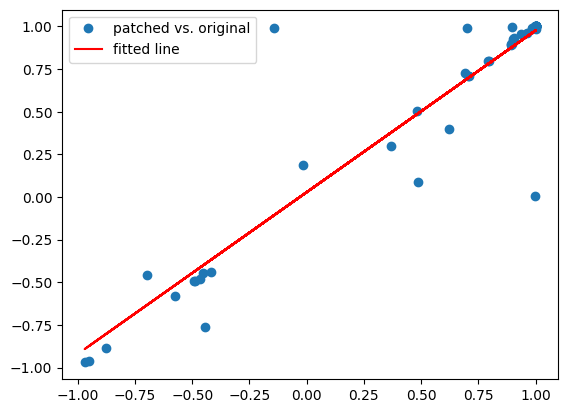

In [16]:
line = stats.linregress(dsq_sim_patched, dsq_sim_original)
print(line)
plt.plot(dsq_sim_patched, dsq_sim_original, 'o', label='patched vs. original')
plt.plot(dsq_sim_patched, line.intercept + line.slope*np.array(dsq_sim_patched), 'r', label='fitted line')
plt.legend()
plt.show()

### Probability of going the right way on the decision square

In [17]:
def _pathfind(grid: np.ndarray, start, end):
    cost, came_from, extra = maze.shortest_path(grid, start, stop_condition=lambda _, sq: sq == end)
    return maze.reconstruct_path(came_from, extra['last_square'])

In [18]:
def deltas_from(grid: np.ndarray, sq):
    path_to_cheese = _pathfind(grid, sq, maze.get_cheese_pos(grid))
    path_to_top_right = _pathfind(grid, sq, (grid.shape[0]-1, grid.shape[1]-1))
    delta_cheese = (path_to_cheese[1][0] - sq[0], path_to_cheese[1][1] - sq[1])
    delta_tr = (path_to_top_right[1][0] - sq[0], path_to_top_right[1][1] - sq[1])
    return delta_cheese, delta_tr

In [35]:
def get_decision_probs(vf):
    "From the decision square, return probabilities of going to the cheese or top right."

    grid = vf['grid']
    i = _decision_square_index(vf)
    probs_dict = {k: v for k,v in zip(models.MAZE_ACTION_INDICES.keys(), vf['probs'][i])}
    action_delta = models.MAZE_ACTION_DELTAS[max(probs_dict, key=probs_dict.get)]

    dsq = metrics.decision_square(grid)
    csq = maze.get_cheese_pos(grid)

    delta_cheese, delta_tr = deltas_from(grid, dsq)
    cheese_dir = models.MAZE_ACTION_DELTAS.inverse[delta_cheese]
    topright_dir = models.MAZE_ACTION_DELTAS.inverse[delta_tr]
    # if topright_dir in ('RIGHT', 'UP'):
    #     raise ValueError('filtering by mazes where the mouse has to go down/left to get to the top right')
    return probs_dict[cheese_dir], probs_dict[topright_dir]


get_decision_probs(vfields[4]['original_vfield'])

(0.09880749136209488, 0.7402361631393433)

cheese is UP, top right is RIGHT
mouse picked RIGHT with prob 0.7402361631393433


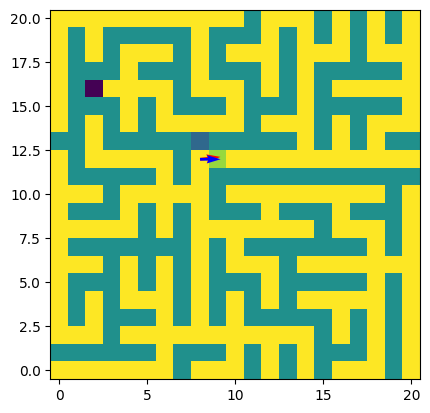

In [36]:
vfs = vfields[4]
vf = vfs['original_vfield']
grid = vf['grid'].copy()

i = _decision_square_index(vf)
probs_dict = {k: v for k,v in zip(models.MAZE_ACTION_INDICES.keys(), vf['probs'][i])}
action_delta = models.MAZE_ACTION_DELTAS[max(probs_dict, key=probs_dict.get)]

dsq = metrics.decision_square(grid)
csq = maze.get_cheese_pos(grid)

delta_cheese, delta_tr = deltas_from(grid, dsq)
grid[(dsq[0]+delta_cheese[0], dsq[1]+delta_cheese[1])] = 35
grid[(dsq[0]+delta_tr[0], dsq[1]+delta_tr[1])] = 85


print(f'cheese is {models.MAZE_ACTION_DELTAS.inverse[delta_cheese]}, top right is {models.MAZE_ACTION_DELTAS.inverse[delta_tr]}')
print(f'mouse picked {max(probs_dict, key=probs_dict.get)} with prob {probs_dict[max(probs_dict, key=probs_dict.get)]}')


plt.imshow(grid, origin='lower')
plt.quiver(dsq[1], dsq[0], [vf['arrows'][i][1]], [vf['arrows'][i][0]], color='red')
plt.quiver(dsq[1], dsq[0], [action_delta[1]], [action_delta[0]], color='blue')
plt.show()

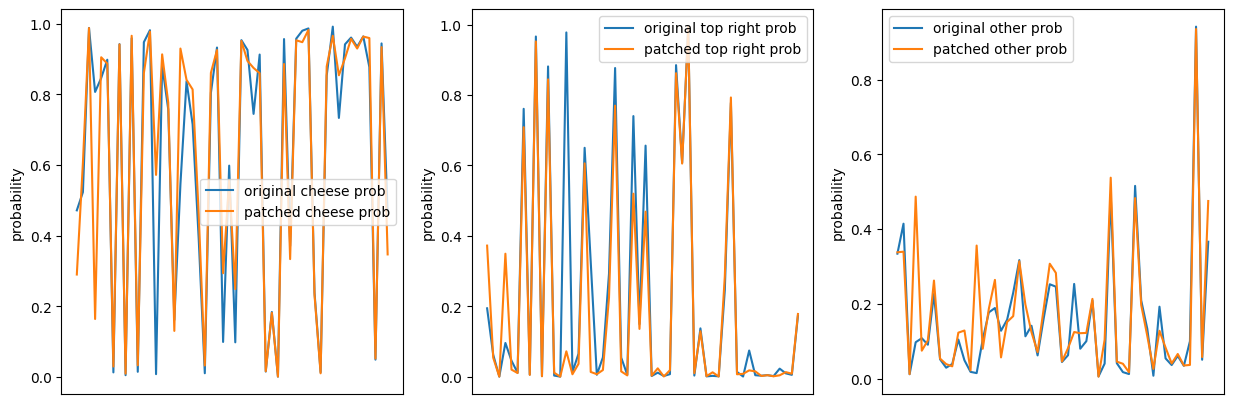

In [55]:
decision_probs_original = []
decision_probs_patched = []

for vfs in vfields:
    if vfs['coeff'] == 0.5 and metrics.decision_square(vfs['original_vfield']['grid']) is not None:
        try:
            decision_probs_original.append(get_decision_probs(vfs['original_vfield']))
            decision_probs_patched.append(get_decision_probs(vfs['patched_vfield']))
        except ValueError:
            pass


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a in ax:
    a.set_xticks([])
    a.set_ylabel('probability')


ax[0].plot([p[0] for p in decision_probs_original], label='original cheese prob')
ax[0].plot([p[0] for p in decision_probs_patched], label='patched cheese prob')
ax[0].legend()

ax[1].plot([p[1] for p in decision_probs_original], label='original top right prob')
ax[1].plot([p[1] for p in decision_probs_patched], label='patched top right prob')
ax[1].legend()

ax[2].plot([1-p[0]-p[1] for p in decision_probs_original], label='original other prob')
ax[2].plot([1-p[0]-p[1] for p in decision_probs_patched], label='patched other prob')
ax[2].legend()

plt.show()

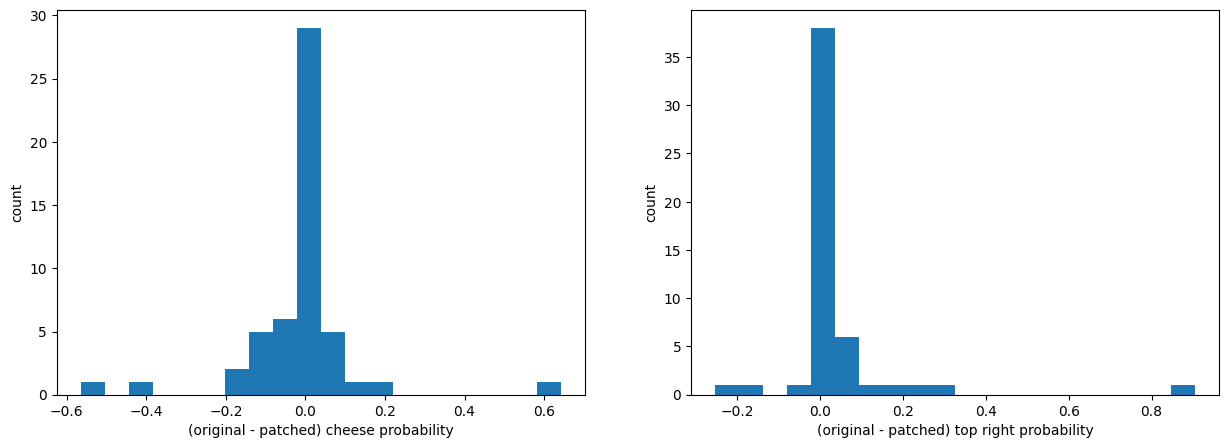

In [61]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, label in zip([0,1], ['cheese', 'top right']):
    prob_diff = (np.array([p[i] for p in decision_probs_original]) - np.array([p[i] for p in decision_probs_patched]))
    ax[i].hist(prob_diff, bins=20)
    ax[i].set_ylabel('count')
    ax[i].set_xlabel(f'(original - patched) {label} probability')
plt.show()

### Get step-wise dot products along the shortest path